<a href="https://colab.research.google.com/github/wayne540500/CNN_PyTorch_MNIST_IMAGE/blob/main/CNN_PyTorch_MNIST_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# convert mnist image into a tensor of 4-dimensions (num of images, height, weigth, color channel)
transform = transforms.ToTensor()

In [3]:
# train data
train_data = datasets.MNIST(root = '/CNN_DATA', train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 198435033.00it/s]

Extracting /CNN_DATA/MNIST/raw/train-images-idx3-ubyte.gz to /CNN_DATA/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30148256.30it/s]


Extracting /CNN_DATA/MNIST/raw/train-labels-idx1-ubyte.gz to /CNN_DATA/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 198168755.45it/s]

Extracting /CNN_DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to /CNN_DATA/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4354406.58it/s]


Extracting /CNN_DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to /CNN_DATA/MNIST/raw



In [4]:
# test data
test_data = datasets.MNIST(root = '/CNN_DATA', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /CNN_DATA
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
# create small batch size of image
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
# define cnn model
# describe cnn and what its doing (2 layer)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)



In [8]:
# grab 1 MNIST image
for i , (X_Train, y_train) in enumerate(train_data):
  break

In [9]:
X_Train.shape

torch.Size([1, 28, 28])

In [10]:
x = X_Train.view(1,1,28,28)

In [11]:
# perform first cnn
x = F.relu(conv1(x))

In [12]:
# 1 single image, 6 is the filter we asked for, 26*26 discharge 2 pixel cause the good stuff is in the middle
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
# pass thru pooling layer
x = F.max_pool2d(x,2,2)  # kernel  of 2 and stride of 2

In [14]:
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
# do our second convolution layer
x = F.relu(conv2(x))

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
# pooling layer
x = F.max_pool2d(x,2,2)

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
# model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # fully connected later
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2*2 kernel stride
    # second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2*2 kernel stride

    # review our data to flatten out
    X = X.view(-1, 16*5*5)  # -1 so we can vary the batch size

    # fully connected layer
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)


In [20]:
# create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)  # the smaller the learning rate the longer the time to train

In [22]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.1623610556125641
Epoch: 0  Batch: 1200  Loss: 0.1502392590045929
Epoch: 0  Batch: 1800  Loss: 0.4744560718536377
Epoch: 0  Batch: 2400  Loss: 0.14238706231117249
Epoch: 0  Batch: 3000  Loss: 0.007758188061416149
Epoch: 0  Batch: 3600  Loss: 0.3836284875869751
Epoch: 0  Batch: 4200  Loss: 0.0038223876617848873
Epoch: 0  Batch: 4800  Loss: 0.0021286322735249996
Epoch: 0  Batch: 5400  Loss: 0.0569545142352581
Epoch: 0  Batch: 6000  Loss: 0.00038789428072050214
Epoch: 1  Batch: 600  Loss: 0.005851339548826218
Epoch: 1  Batch: 1200  Loss: 0.3855525553226471
Epoch: 1  Batch: 1800  Loss: 0.004819948226213455
Epoch: 1  Batch: 2400  Loss: 0.003216963727027178
Epoch: 1  Batch: 3000  Loss: 0.0332382395863533
Epoch: 1  Batch: 3600  Loss: 0.5372857451438904
Epoch: 1  Batch: 4200  Loss: 0.04561494290828705
Epoch: 1  Batch: 4800  Loss: 0.0007510822033509612
Epoch: 1  Batch: 5400  Loss: 0.0001173773780465126
Epoch: 1  Batch: 6000  Loss: 0.14201366901397705
Epoch: 2  Batch

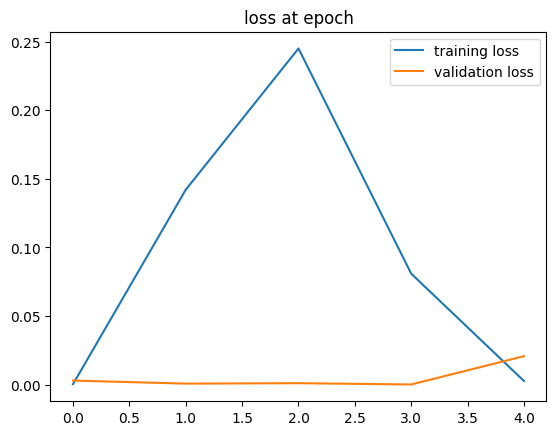

In [23]:
# graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="validation loss")
plt.title("loss at epoch")
plt.legend()

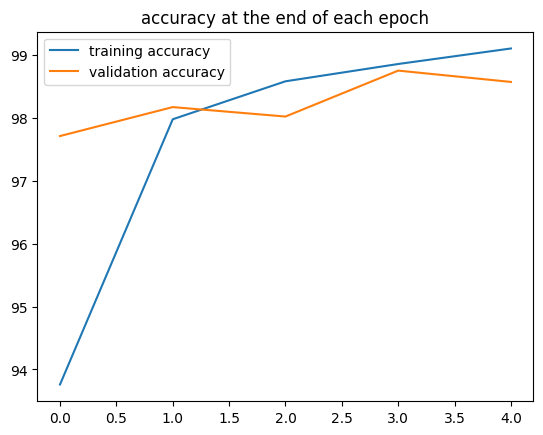

In [24]:
# graph the accuracy at the end of epoch
plt.plot([t/600 for t in train_correct], label="training accuracy")
plt.plot([t/100 for t in test_correct], label="validation accuracy")
plt.title("accuracy at the end of each epoch")
plt.legend()

In [25]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [27]:
# did for correct
correct.item()/len(test_data)

0.9857

In [28]:
# grab an image
test_data[4143] # tensor with an image in it , at the end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [29]:
# grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [30]:
# reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

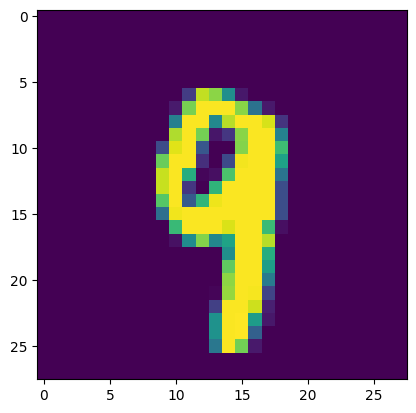

In [31]:
# show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [32]:
# pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28))  # batch size of 1, 1color channel, 28*28


In [34]:
# check new prediction get probability
new_prediction

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [37]:
new_prediction.argmax() # we only want the biggest from tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
        # -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])
        # 出來的結果 tensor(9) our model 判定是 9

tensor(9)

In [ ]:
# 如果想測試不同 數字 把 4143 改成其他 data 編號就好 ex: 改成 1994 or 2001 etc.